# Data-Driven Employee Insights: Sentiment Scoring, Risk Identification, and Predictive Analysis

## Task 1: Sentiment Labeling

**Objective:** Label each employee message with a sentiment category: **Positive**, **Neutral**, or **Negative**.  
In this task, I used a pretrained transformer model (cardiffnlp/twitter-roberta-base-sentiment) to analyze employee messages and classify them by sentiment. This labeled data will be used for further analysis and scoring.

In [130]:
#pip install huggingface_hub[hf_xet]

### 🔍 Step 1: Importing Required Libraries

In [131]:
#Import Libraries
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, pipeline

### 📂 Step 2: Load Dataset

In [198]:
#Load the employee emails dataset
df = pd.read_csv("test(in).csv")

### 🧼 Step 3: Preprocess Emails Body

In [199]:
# Get all employee usernames from emails
names = df['from'].apply(lambda x: x.split('@')[0]).unique().tolist()
names = [name.lower() for name in names]

# Function to clean the body
def preprocess(text):
    if pd.isna(text):
        return ""
    text = re.sub(r"(Best regards|Sincerely|Kind regards|Cheers|Regards|Thanks|Thank you).*", "", text, flags=re.IGNORECASE)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip().lower()
# Remove names
    for name in names:
        text = re.sub(rf"\b{name}\b", "", text)


    return text
    
# Apply preprocessing
df['body'] = df['body'].apply(preprocess)

# Remove empty messages
df = df[df['body'].str.strip() != ""]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2152 entries, 0 to 2190
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Subject  2152 non-null   object
 1   body     2152 non-null   object
 2   date     2152 non-null   object
 3   from     2152 non-null   object
dtypes: object(4)
memory usage: 84.1+ KB


**Observation:** I removed any standard closing phrases, employee usernames in the email body, and extra white spaces. Empty messages were dropped after preprocessing.

### 🧠 Step 4: Load Sentiment Model

In [200]:
# Load the transformer model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

### 🤖 Step 5: Create Sentiment Pipeline

In [201]:
# Create the sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Device set to use cpu


### 🧾 Step 6: Analyze Sentiment

In [202]:
# Map model labels to readable names
label_map = {
    "LABEL_0": "Negative",
    "LABEL_1": "Neutral",
    "LABEL_2": "Positive"
}

# Function to return sentiment and confidence score
def analyze(text):
    result = sentiment_pipeline(text[:512])[0]  # Truncate long texts
    return label_map[result['label']], result['score']

# Apply to all emails
df[['predicted_label', 'sentiment_score']] = df['body'].apply(lambda x: analyze(x)).apply(pd.Series)

### 💾 Step 7: Save Final Data

In [203]:
# Save the new dataset with sentiment labels
df.to_csv("test_with_predictions.csv", index=False)

**Model Selection Rationale**

We evaluated multiple models for sentiment classification, including TextBlob and VADER, which are popular lexicon-based tools. However, both are optimized for informal text like tweets and may misinterpret formal workplace communication. Additionally, they require setting custom thresholds to map sentiment scores to categories, which can be arbitrary without domain tuning.

In contrast, `cardiffnlp/twitter-roberta-base-sentiment`, despite being trained on tweets, performed better during manual validation. We reviewed 10–12 sample emails and found Roberta's predictions aligned more closely with human judgment. It also returns sentiment labels directly without thresholding, reducing bias. For these reasons, we selected Roberta for sentiment tagging.


## Task 2: Exploratory Data Analysis

**Objective:**  
To understand the structure, distribution, and trends in the dataset. This analysis helps surface key patterns in employee communication and sentiment that will be important for later tasks like scoring and risk prediction.

### 📂 Section 1: Dataset Overview

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [204]:
# Load dataset with sentiment labels
df2 = pd.read_csv('test_with_predictions.csv')

I begin by inspecting the structure of the dataset (from task 1- the sentiment labels were generated using Roberta) including data types, number of records, and checking for missing values.

In [205]:
# Basic info
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152 entries, 0 to 2151
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Subject          2152 non-null   object 
 1   body             2152 non-null   object 
 2   date             2152 non-null   object 
 3   from             2152 non-null   object 
 4   predicted_label  2152 non-null   object 
 5   sentiment_score  2152 non-null   float64
dtypes: float64(1), object(5)
memory usage: 101.0+ KB


In [206]:
# Summary statistics for numerical columns
df2.describe()

,sentiment_score
count,2152.000000
mean,0.788089
std,0.141316
min,0.422951
25%,0.684908
50%,0.830566
75%,0.907596
max,0.993396


**Observations:**
- The dataset contains 2,152 email records.
- All columns are non-null, so there are no missing values.
- Sentiment scores range from ~0.42 to ~0.99, indicating varied confidence levels.
- Except for sentiment score, all data types are object. We will convert to the required data format as needed.

### 📊 Section 2: Sentiment Distribution

We explore how the sentiment labels (Positive, Neutral, Negative) are distributed.

In [207]:
# Count of each sentiment
df2['predicted_label'].value_counts()

predicted_label
Neutral     1515
Positive     480
Negative     157
Name: count, dtype: int64

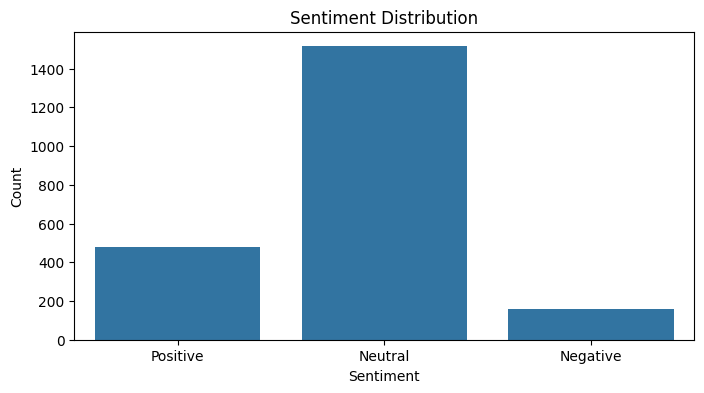

In [208]:
# Plot sentiment distribution
plt.figure(figsize=(8,4))
sns.countplot(x = 'predicted_label', data = df2,order = ['Positive', 'Neutral', 'Negative'])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.savefig("visualizations/sentiment_distributions.png")
plt.show()



**Observations:**
- The majority of emails are labeled as Neutral (1,515).
- Positive emails: 480, Negative emails: 157.

Most of the messages were labeled as Neutral, which makes sense since corporate emails are usually formal and focused on sharing information. In professional settings, people tend to avoid emotional language, so this neutral tone is expected. The fact that there are a good number of Positive emails suggests that appreciation or recognition happens fairly often. On the other hand, the fewer Negative messages might point to occasional issues or disagreements—something that could be worth keeping an eye on.


### 🕒 Section 3: Time-Based Trends

We convert the `date` column to datetime format and analyze sentiment trends over 2010 and 2011.

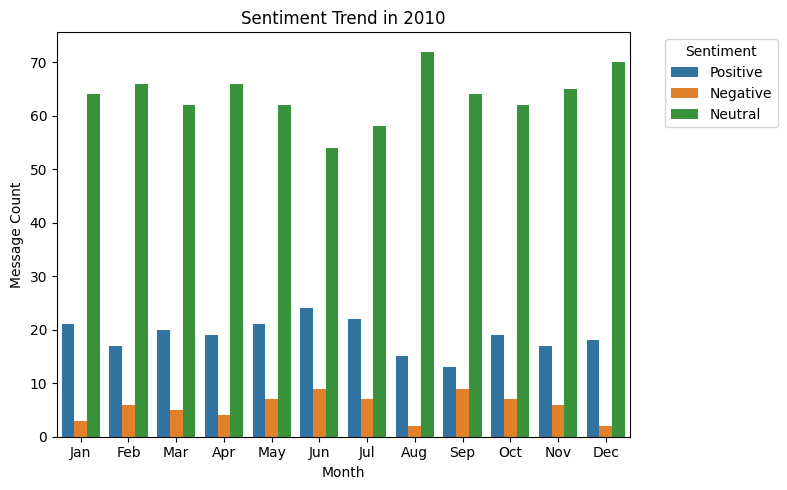

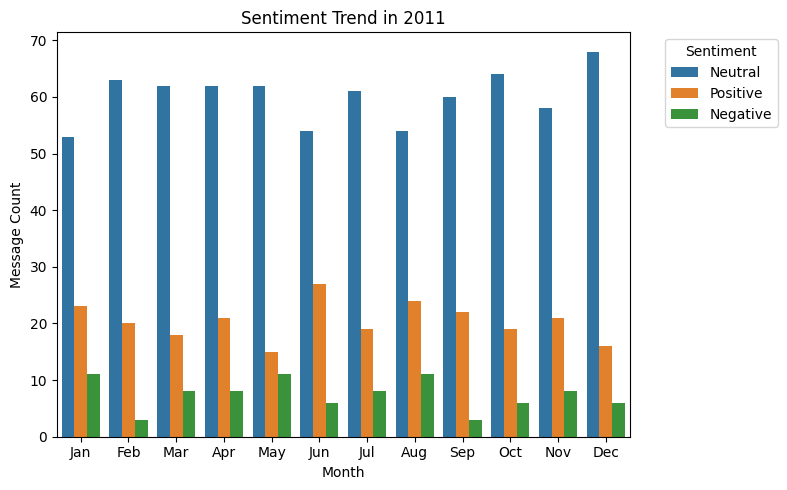

In [209]:
# Convert date
df2['date']= pd.to_datetime(df['date'], errors = 'coerce')
df2['year'] = df2['date'].dt.year
df2['month'] = df2['date'].dt.strftime('%b')  # 'Jan', 'Feb', etc.
df2['month_num'] = df2['date'].dt.month


# Group by year, month, and sentiment
grouped = df2.groupby(['year', 'month', 'month_num', 'predicted_label']).size().reset_index(name='count')

# Sort by actual calendar month
grouped = grouped.sort_values(by='month_num')

# Filter for each year
df2_2010 = grouped[grouped['year'] == 2010]
df2_2011 = grouped[grouped['year'] == 2011]

# Plot for 2010
plt.figure(figsize=(8, 5))
sns.barplot(data=df2_2010, x='month', y='count', hue='predicted_label')
plt.title('Sentiment Trend in 2010')
plt.xlabel('Month')
plt.ylabel('Message Count')
plt.legend(title='Sentiment')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("visualizations/sentiment_trend_2010.png")
plt.show()

# Plot for 2011
plt.figure(figsize=(8, 5))
sns.barplot(data=df2_2011, x='month', y='count', hue='predicted_label')
plt.title('Sentiment Trend in 2011')
plt.xlabel('Month')
plt.ylabel('Message Count')
plt.legend(title='Sentiment')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("visualizations/sentiment_trend_2011.png")
plt.show()

**Observations:**
- In 2010, Neutral sentiment dominates every month. Positive sentiment is relatively consistent.
- In 2011, Neutral and Positive emails increase, while Negative emails decrease slightly.  

This shift might suggest that company culture was improving—possibly due to leadership changes or better communication practices. Even small changes in how people express themselves can reflect shifts in employee morale, which is something HR and management should keep an eye on.

### ☁️ Section 4: Word Clouds by Sentiment

We generate word clouds for each sentiment category to visualize commonly used words in different emotional tones.

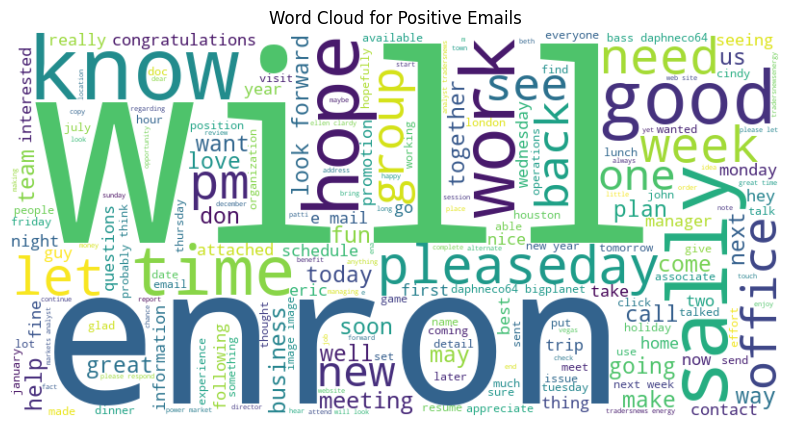

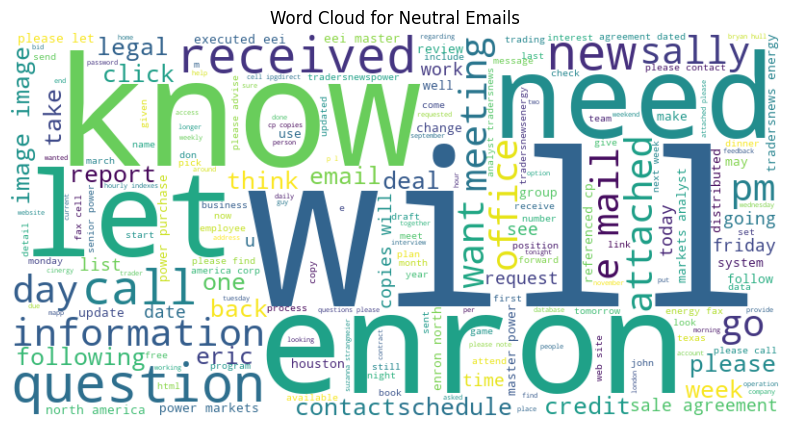

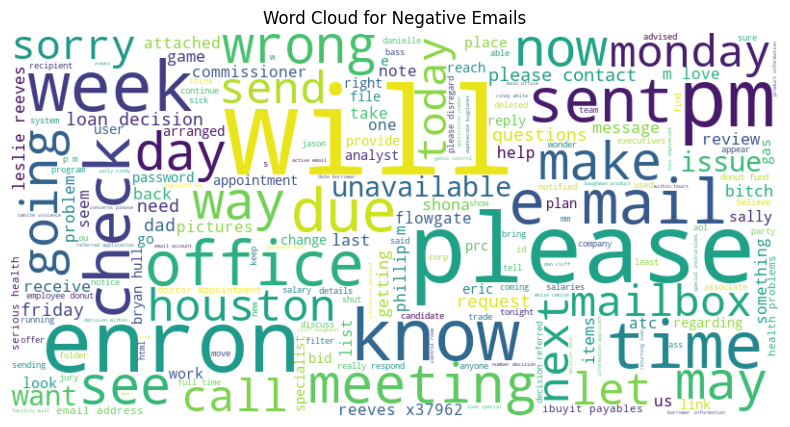

In [210]:
for sentiment in ['Positive', 'Neutral', 'Negative']:
    text = " ".join(df2[df2['predicted_label'] == sentiment]['body'].dropna().astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {sentiment} Emails")
    plt.savefig("visualizations/word_cloud_for_positive_emails.png")
    plt.savefig("visualizations/word_cloud_for_neutral_emails.png")
    plt.savefig("visualizations/word_cloud_for_negative_emails.png")
    plt.show()

**Observations:**
- Positive emails frequently contain words like “great,” “appreciate,” “congrats,” showing gratitude and celebration.
- Neutral emails focus on functional terms like “schedule,” “meeting,” “report,” which reinforces the notion of business-as-usual communications.
- Negative emails include phrases like “sorry,” “problem,” “unavailable,” suggesting unmet expectations or blockers. These may be early warning signs for workflow issues or employee frustration.

These word clouds help decode not just what people are saying, but how they feel — essential for any workplace engagement strategy.



### 📏 Section 5: Message Length Analysis

We examine whether sentiment correlates with message length.

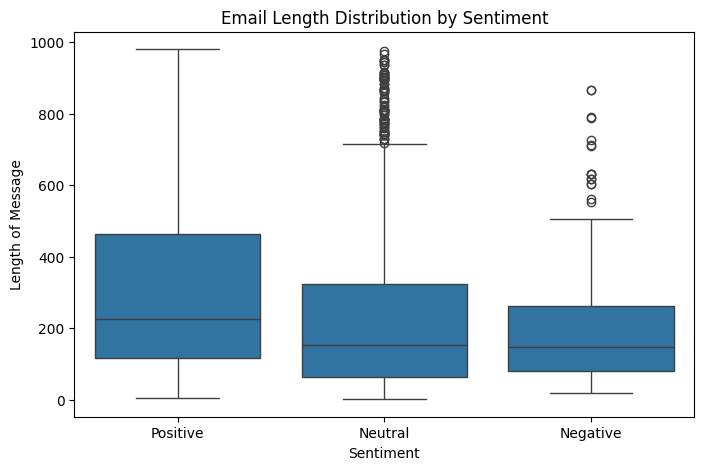

In [148]:
df2['message_length'] = df2['body'].astype(str).apply(len)

plt.figure(figsize=(8,5))
sns.boxplot(data=df2, x='predicted_label', y='message_length', order=['Positive', 'Neutral', 'Negative'])
plt.title("Email Length Distribution by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Length of Message")
plt.savefig("visualizations/email_length_distribution_by_sentiment.png")
plt.show()

**Observations:**  
The longer average length of Positive emails may reflect detailed recognition or thoughtful communication. In contrast, Negative messages tend to be shorter and sharper, which could imply abrupt feedback, stress, or urgency. Identifying these concise, negative exchanges may help flag possible disengagement or tension early on.



### Summary of EDA

- Majority of emails are neutral in tone.
- Positive communication increased in 2011.
- Word usage differs significantly between sentiment categories.
- Longer emails are more likely to be positive.

These insights will guide our employee scoring and risk identification in the next tasks.

## Task 3: Employee Score Calculation

**Objective:**  
To compute monthly sentiment scores for each employee based on the tone of their email messages.

**Scoring Rules:**  
- Positive Message → +1  
- Neutral Message → 0  
- Negative Message → –1  

We aggregate the scores by month to understand each employee’s sentiment trend over time. These scores will be used in subsequent steps for employee ranking and flight risk analysis.

### 🧠 Step 1: Map Sentiment to Score

In [149]:
# Define the scoring system
score_label= {
    'Positive': +1,
    'Negative': -1,
    'Neutral': 0
}

# Map score to sentiment
df2['sentiment_score'] = df2['predicted_label'].map(score_label)

**Comment:**  
We mapped sentiment labels into numerical scores based on their emotional polarity to quantify employee sentiment per message. This scoring method aligns with conventional sentiment quantification, offering a straightforward way to track emotional tone over time.


### 📆 Step 3: Convert to Monthly Format

In [150]:
# Convert the date column to datetime and extract year-month
df2['date']= pd.to_datetime(df2['date'], errors = 'coerce')
df2['year_month'] = df2['date'].dt.to_period('M')

**Comment:**  
We convert the `date` column to proper datetime format and extract the **`year_month`** as a period value (e.g., `'2010-03'`). This allows us to later group messages by sender and month for sentiment score aggregation.

### 📊 Step 4: Group and Aggregate Sentiment Scores

In [151]:
# Aggregate sentiment score by employee and month
monthly_scores = df2.groupby(['from', 'year_month'])['sentiment_score'].sum().reset_index()

# Rename the column for clarity
monthly_scores.rename(columns={'sentiment_score': 'monthly_sentiment_score'})

# Save the results
monthly_scores.to_csv("monthly_sentiment_scores.csv", index=False)

**Comment:**  
We group the dataset by both `from` (employee email) and `year_month`, then sum the sentiment scores for each group. This gives us a new table (`monthly_scores`) where each row shows an employee’s total sentiment score for a given month.

For example, if an employee sent:
- 2 positive emails (+1 each)
- 1 neutral email (0)
- 1 negative email (–1)

...in March 2010, their score would be: **+1 +1 +0 –1 = +1**


In [152]:
# Display the first few rows of the final table
monthly_scores.head()

,from,year_month,sentiment_score
0,bobette.riner@ipgdirect.com,2010-01,1
1,bobette.riner@ipgdirect.com,2010-02,-3
2,bobette.riner@ipgdirect.com,2010-03,1
3,bobette.riner@ipgdirect.com,2010-04,-1
4,bobette.riner@ipgdirect.com,2010-05,3


### 📊 Monthly Sentiment Trend for a Sample Employee

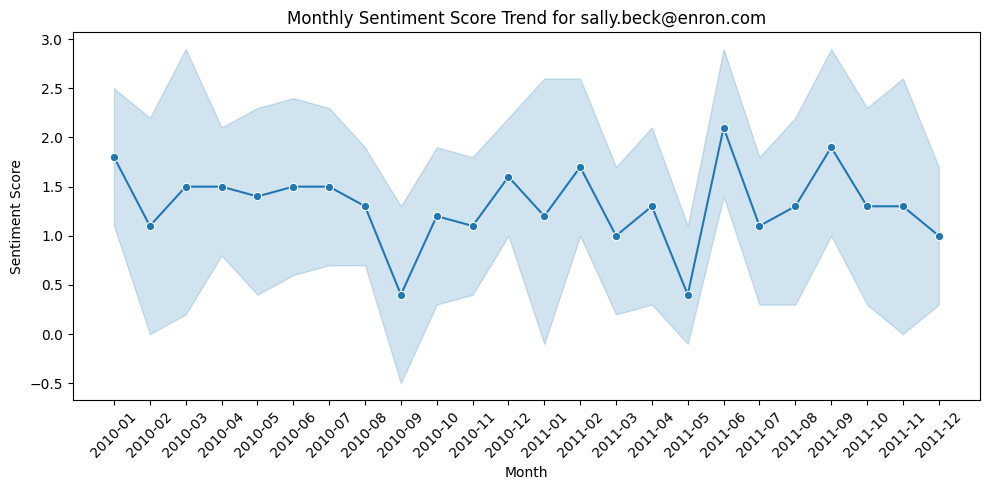

In [153]:
# Convert year_month to string for plotting
monthly_scores['year_month'] = monthly_scores['year_month'].astype(str)

# Pick a sample employee for visualization
sample_emp = 'sally.beck@enron.com'

# Filter their monthly sentiment data
sample_df = monthly_scores[monthly_scores['from'] == sample_emp]

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_scores, x='year_month', y='sentiment_score', marker='o')
plt.title(f"Monthly Sentiment Score Trend for {sample_emp}")
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Sentiment Score")
plt.tight_layout()
plt.savefig("visualizations/monthly_sentiment_scored_trend_for_sally.beck@enron.com.png")
plt.show()


### Observation
The trend for `sally.beck@enron.com` shows a noticeable dip in mid-2010 followed by a steady increase in sentiment across 2011. This upward trend may reflect improved employee experience or engagement over time. Tracking such trends can help HR identify at-risk individuals and measure the impact of interventions.


## 📌 Task 4: Employee Ranking Based on Sentiment Score

#### 🎯 Objective  
Generate ranked lists of employees per month based on sentiment scores. This includes:

- Top 3 positive employees (highest sentiment scores)

- Top 3 negative employees (lowest sentiment scores)

The rankings are sorted:

- By sentiment_score (descending for positives, ascending for negatives)

- Then alphabetically by employee email if there's a tie

### 🔍 Step 1: Load Monthly Sentiment Data

In [154]:
# Load monthly sentiment scores (calculated in Task 3)
df3= pd.read_csv('monthly_sentiment_scores.csv')

# Quick look at the data
df3.head()

,from,year_month,sentiment_score
0,bobette.riner@ipgdirect.com,2010-01,1
1,bobette.riner@ipgdirect.com,2010-02,-3
2,bobette.riner@ipgdirect.com,2010-03,1
3,bobette.riner@ipgdirect.com,2010-04,-1
4,bobette.riner@ipgdirect.com,2010-05,3


### ⚙️ Step 2: Extract Top Positive and Negative Employees

In [155]:
# Top 3 Positive Employees per month
top_positive = (df3.sort_values(["year_month", "sentiment_score", "from"], ascending=[True, False, True])
    .groupby('year_month').head(3).assign(rank_type="Top Positive")
)

# Top 3 Negative Employees per month
top_negative = (
    df3.sort_values(["year_month", "sentiment_score", "from"], ascending=[True, True, True])
    .groupby("year_month")
    .head(3)
    .assign(rank_type="Top Negative")
)

# Combine both rankings
rankings = pd.concat([top_positive, top_negative])

### ✅ Step 3: Sort Rankings for Presentation


In [156]:
rankings = rankings.sort_values(by=["year_month", "rank_type", "sentiment_score", "from"],
                                ascending=[True, True, False, True])

### 📊 Step 4: Display the Rankings Table

In [157]:
# Show top 10 rows for verification
rankings[["year_month", "from", "sentiment_score", "rank_type"]].head(10)

,year_month,from,sentiment_score,rank_type
0,2010-01,bobette.riner@ipgdirect.com,1,Top Negative
48,2010-01,eric.bass@enron.com,1,Top Negative
24,2010-01,don.baughman@enron.com,0,Top Negative
168,2010-01,patti.thompson@enron.com,4,Top Positive
72,2010-01,john.arnold@enron.com,3,Top Positive
120,2010-01,kayne.coulter@enron.com,3,Top Positive
73,2010-02,john.arnold@enron.com,1,Top Negative
217,2010-02,sally.beck@enron.com,-1,Top Negative
1,2010-02,bobette.riner@ipgdirect.com,-3,Top Negative
25,2010-02,don.baughman@enron.com,3,Top Positive


### 📈 Step 5: Visualize Sentiment Score Rankings Over Time

**Barplot Summary per Month**

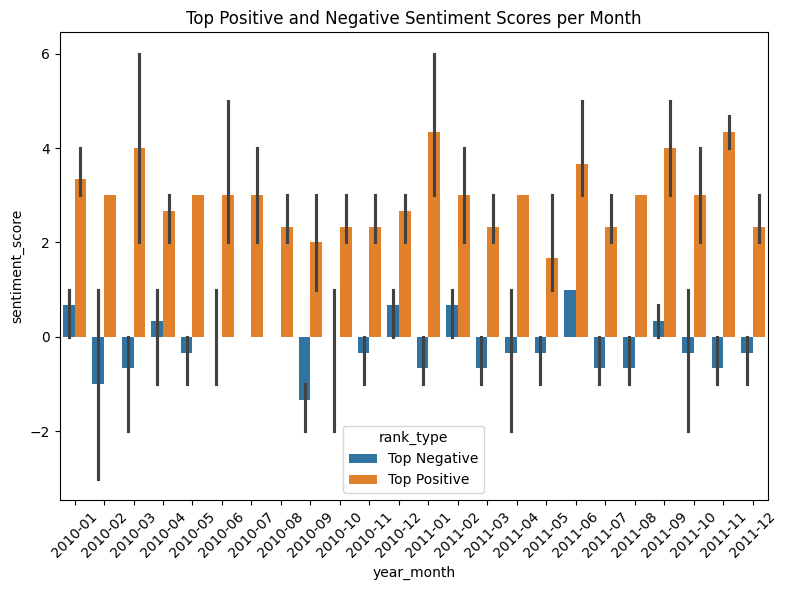

In [194]:
plt.figure(figsize=(8, 6))
sns.barplot(
    data=rankings,
    x="year_month",
    y="sentiment_score",
    hue="rank_type"
)
plt.xticks(rotation=45)
plt.title("Top Positive and Negative Sentiment Scores per Month")
plt.tight_layout()
plt.savefig("visualizations/top_positive_and_negative_scores_per_month.png")
plt.show()


**📈 Observation:**
This barplot compares the strongest positive and negative sentiment scores in emails each month of 2010 and 2011.

- Positive sentiment remains consistently higher than negative, suggesting a generally appreciative communication tone.
- The few but present negative peaks (e.g., 2010-08) may reflect isolated incidents of dissatisfaction or stress.

**💡 Insight:**
High positive scores are good signs of team morale and recognition. However, even isolated strong negative messages can be early signals of employee disengagement or conflict and should be monitored.


**Catplot: Employee Rankings per Month**

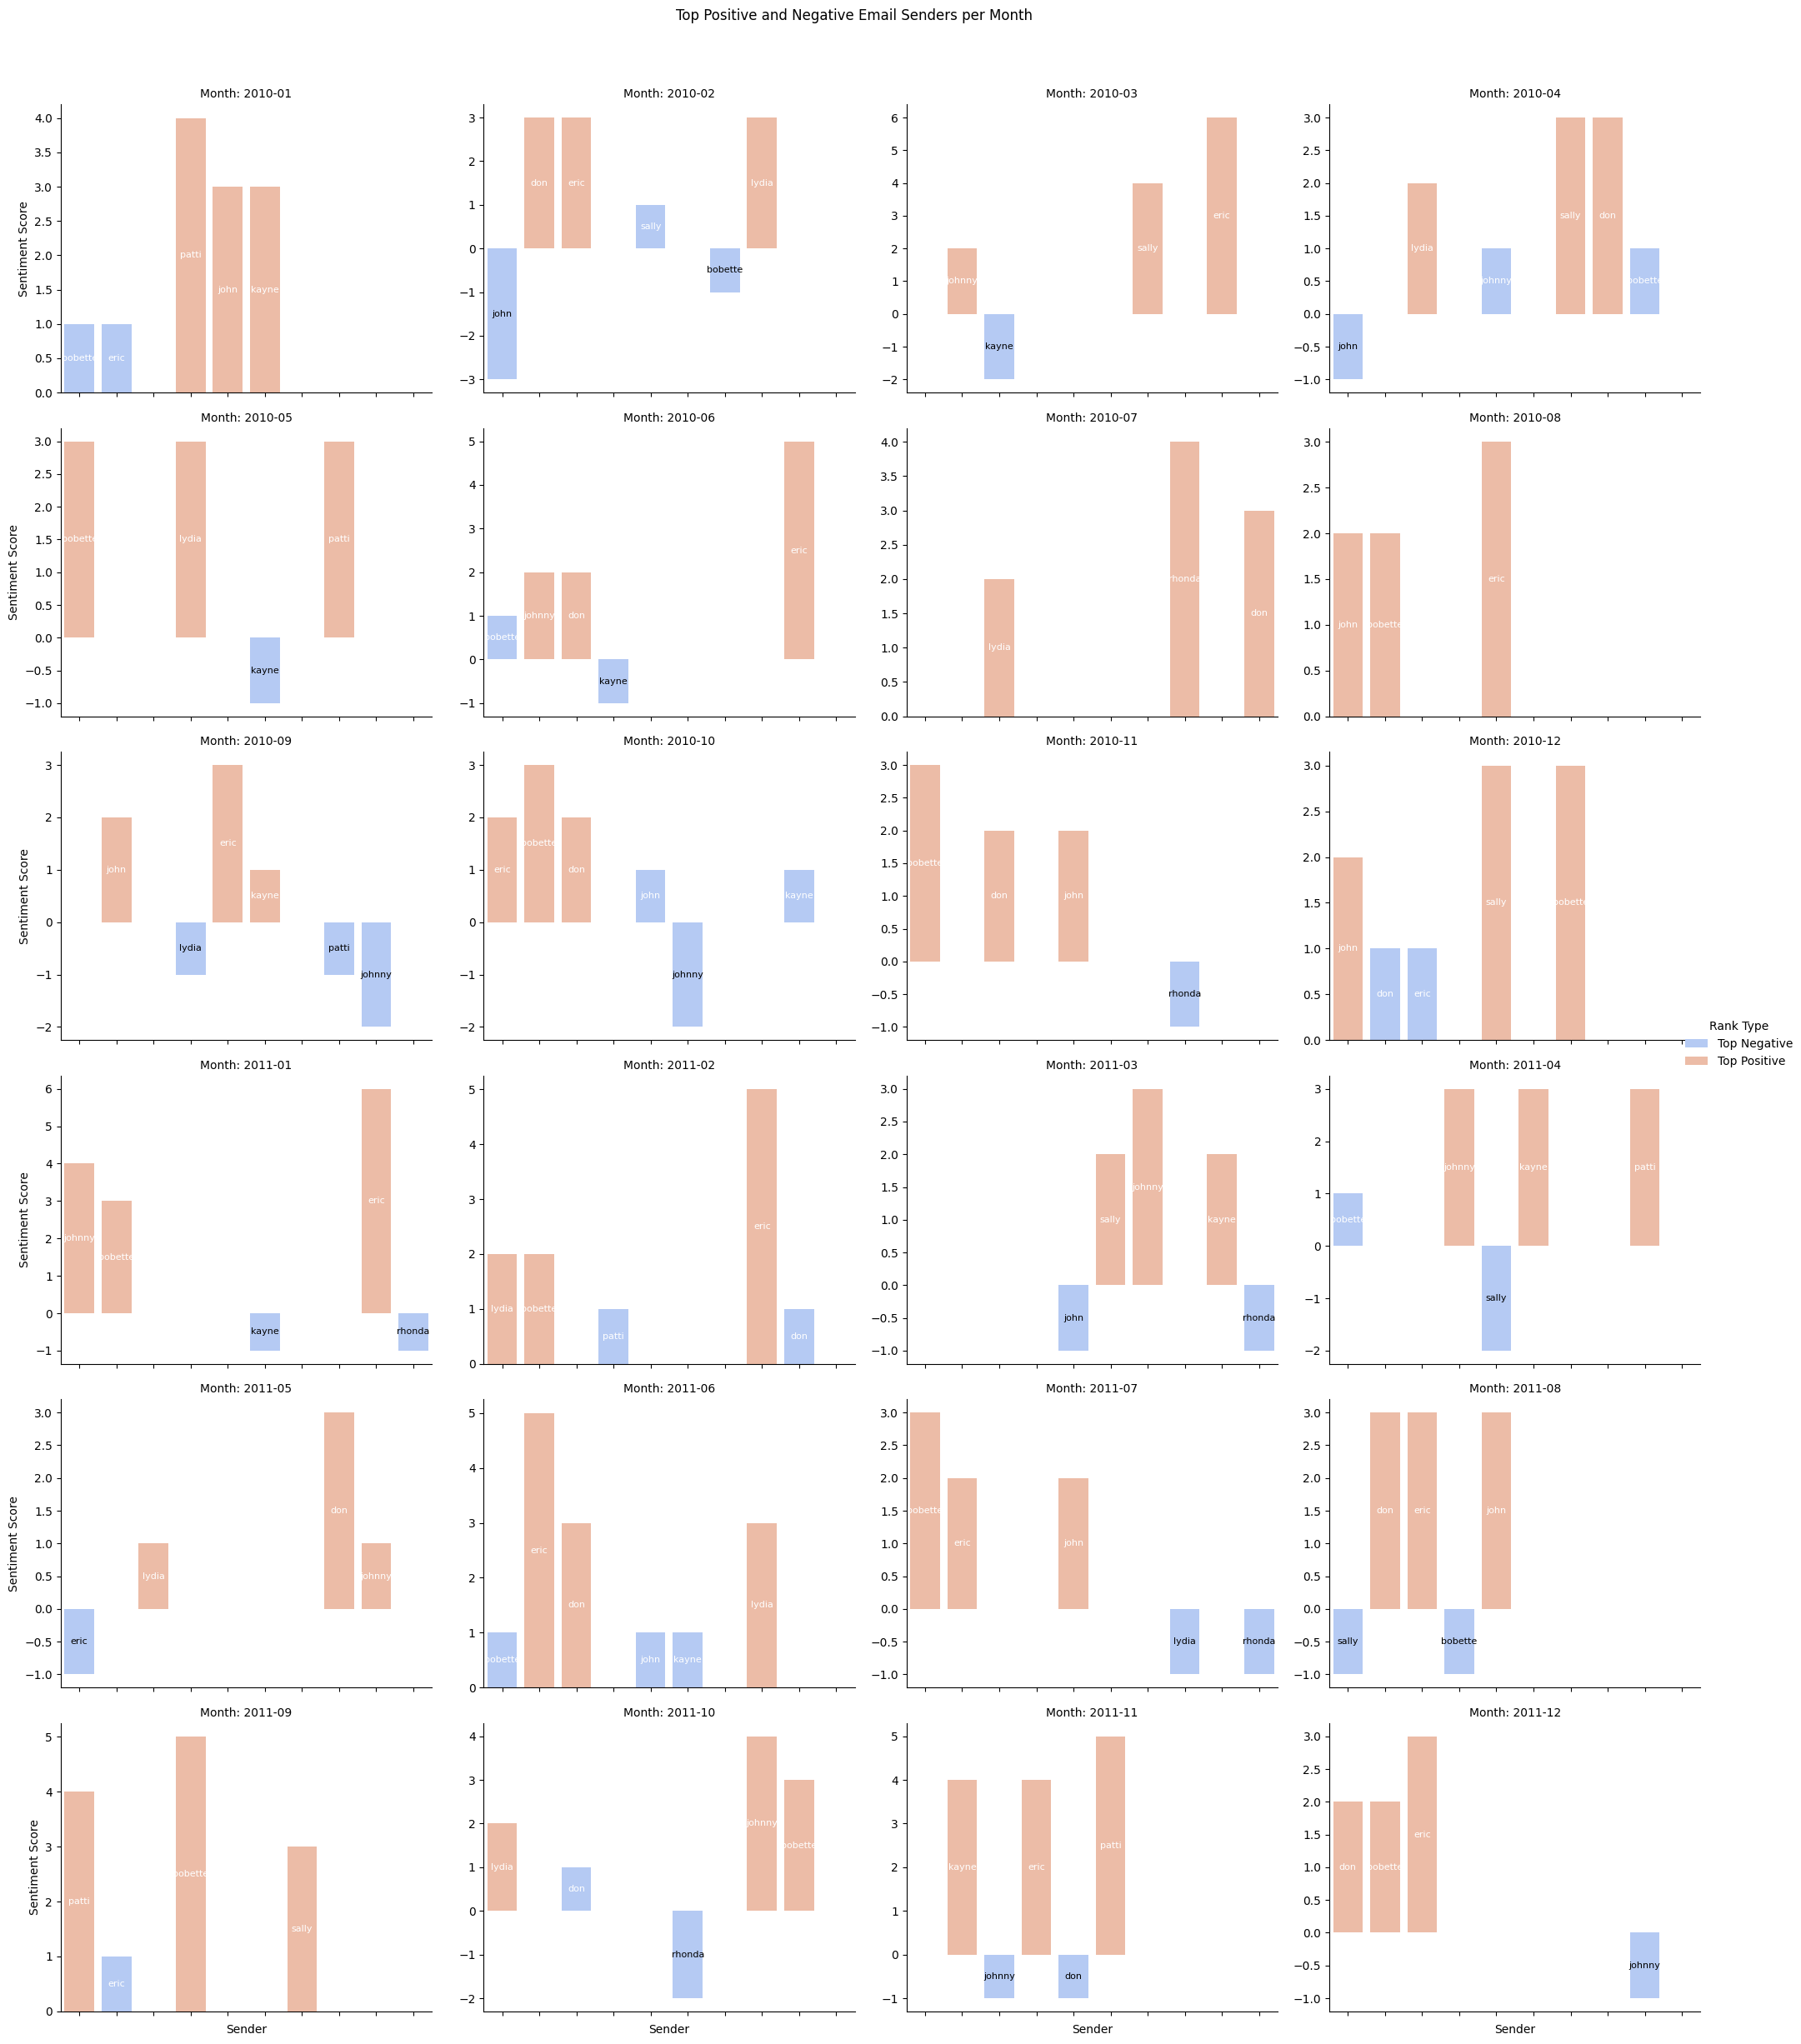

In [212]:
# Extract first names from email
rankings['first_name'] = rankings['from'].str.extract(r'^([^@\.]+)')
g = sns.catplot(
    data=rankings,
    x="from", y="sentiment_score",
    hue="rank_type", col="year_month",
    kind="bar", col_wrap=4, height=4, aspect=1.2,
    palette="coolwarm", sharey=False
)
g._legend.set_bbox_to_anchor((1.05, 0.5))  # Right of the plot
g._legend.set_title("Rank Type")
g.set_titles("Month: {col_name}")
g.set_xticklabels(rotation=90)
g.set_axis_labels("Sender", "Sentiment Score")
g.fig.suptitle("Top Positive and Negative Email Senders per Month", y=1.02)
# Add first name inside each bar
for ax, month in zip(g.axes.flatten(), rankings['year_month'].unique()):
    month_data = rankings[rankings['year_month'] == month]
    for bar, (_, row) in zip(ax.patches, month_data.iterrows()):
        height = bar.get_height()
        if abs(height) > 0.5:  # Only label if bar is tall enough
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height / 2,  # Inside the bar
                row['first_name'],
                ha='center', va='center', fontsize=8, color='white' if height > 0 else 'black'
            )

plt.tight_layout()
plt.savefig("visualizations/top_positive_and_Negative_Email_Senders_per_Month.png")
plt.show()


**📝 Observations**
This faceted bar chart breaks down the top sentiment-scoring email senders per month by positive and negative tone.

- Certain individuals (like lydia, bobette, eric) consistently appear in the top negative or positive ranks, showing a pattern in communication style.
- Some months (like 2011-04) see more diversity in top senders, while others have only a few prominent ones.

**💡 Insight:**
Identifying repeat negative senders can help HR flag potential dissatisfaction or stress early. On the other hand, frequent positive senders might serve as internal motivators or potential team leaders worth acknowledging.



## 📃 Task 5: Flight Risk Identification

#### 🌟 Objective
Identify employees who are at risk of leaving the company by analyzing their negative sentiment email patterns. An employee is considered at flight risk if they send 4 or more negative emails within any 30-day period.


### 🔎 Step 1: Prepare Date Column and Filter Negative Emails Only

In [213]:
# Filter only negative emails
df2 = pd.read_csv('test_with_predictions.csv')
df2['date'] = pd.to_datetime(df2['date'], errors='coerce') 
df_neg = df2[df2['predicted_label'] == 'Negative'].copy()

In [214]:
df_neg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157 entries, 1 to 2143
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Subject          157 non-null    object        
 1   body             157 non-null    object        
 2   date             157 non-null    datetime64[ns]
 3   from             157 non-null    object        
 4   predicted_label  157 non-null    object        
 5   sentiment_score  157 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 8.6+ KB


### 🔄 Step 3: Sort Emails by Sender and Date

In [215]:
# Sort the negative emails by 'from' and 'date'
df_neg = df_neg.sort_values(['from','date'])

In [216]:
df_neg = df_neg.reset_index(drop=True)
df_neg.head()

,Subject,body,date,from,predicted_label,sentiment_score
0,"Enron Federal Credit Union - Loan Response, Ap...",loan decision: referred application number: 72...,2010-04-25,bobette.riner@ipgdirect.com,Negative,0.481387
1,Outage for Unify Gas Users,just a reminder that our unify gas system will...,2010-06-15,bobette.riner@ipgdirect.com,Negative,0.787322
2,Pager Request,does this make sense to you? seems like they m...,2010-07-24,bobette.riner@ipgdirect.com,Negative,0.712060
3,Conference Call on Wednesday morning,i had to report for jury duty today (along wit...,2010-08-06,bobette.riner@ipgdirect.com,Negative,0.474041
4,Sending hourly indexes,i'm sorry for whatever is causing the difficul...,2010-08-09,bobette.riner@ipgdirect.com,Negative,0.673615


### 📅 Step 5: Rolling 30-Day Window Check

In [217]:
# Identify employees at flight risk
employees_at_flight_risk = set()

for sender, group in df_neg.groupby('from'):
    dates = group['date'].tolist()
    n= len(dates)
    start = 0
    for end in range(n):
        while dates[end]-dates[start] > pd.Timedelta(days = 30):
            start += 1
        if(end-start+1) >= 4:
            employees_at_flight_risk.add(sender)
            break

### 🔍 Step 6: Extract and Display Flight Risk List

In [218]:
# Convert to list and display
flight_risk_list = list(employees_at_flight_risk)
flight_risk_list

['don.baughman@enron.com',
 'bobette.riner@ipgdirect.com',
 'sally.beck@enron.com',
 'john.arnold@enron.com']

### 🌐 Step 7: Visualize Negative Email Volume by Employee and Flight Risk List of Empployees

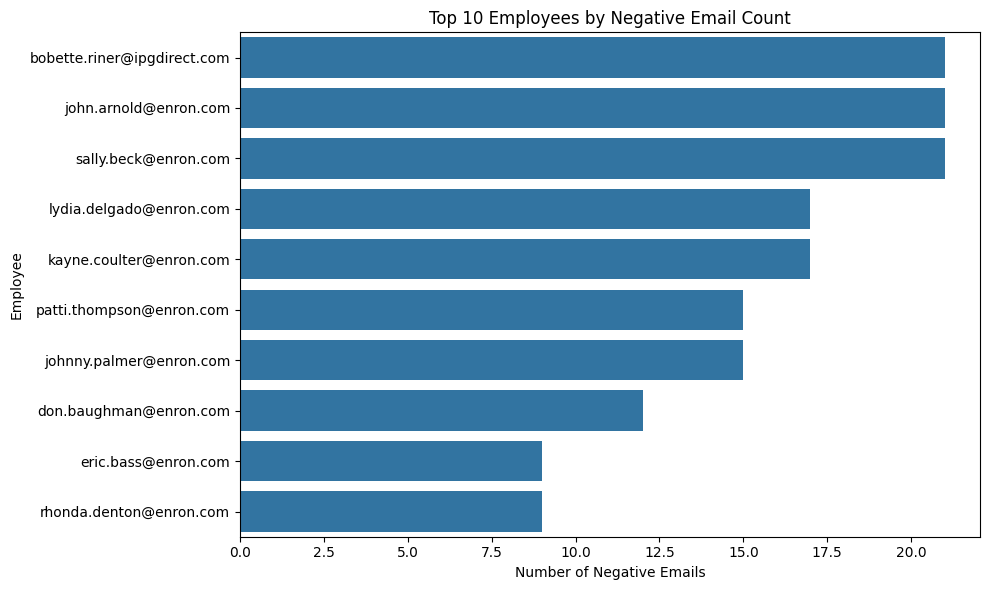

In [219]:
# Count of negative emails per employee
neg_counts = df_neg['from'].value_counts().reset_index()
neg_counts.columns = ['from', 'negative_email_count']

plt.figure(figsize=(10, 6))
sns.barplot(data=neg_counts.head(10), x='negative_email_count', y='from')
plt.title("Top 10 Employees by Negative Email Count")
plt.xlabel("Number of Negative Emails")
plt.ylabel("Employee")
plt.tight_layout()
plt.savefig("visualizations/top_10_employees_by_Negative_Email_count.png")

plt.show()

📌 **Observation**:
This bar chart highlights the top 10 employees who have sent the most negative emails. A high volume of negativity may indicate dissatisfaction, stress, or poor morale. Notably, employees like bobette.riner@ipgdirect.com and john.arnold@enron.com stand out, which could flag them for deeper HR reviews or early interventions.

💡 **Why it matters**:
High negative communication patterns may serve as early indicators of disengagement or internal conflict. By identifying frequent senders of negativity, management can take proactive steps to improve culture, morale, or workload distribution.


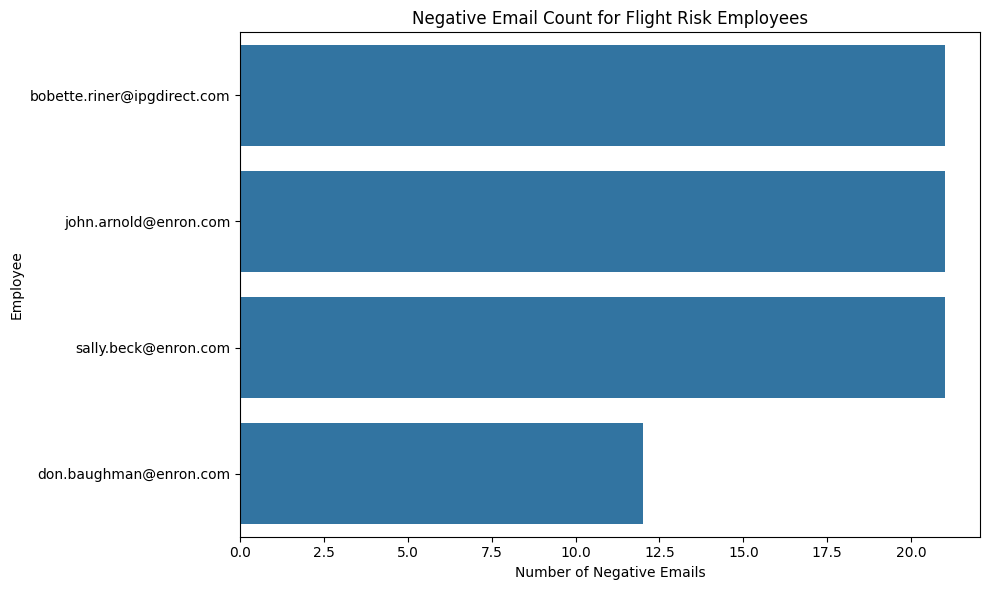

In [220]:
# Filter to only include employees at flight risk
neg_counts_filtered = neg_counts[neg_counts['from'].isin(flight_risk_list)]

# Plot it
plt.figure(figsize=(10, 6))
sns.barplot(data=neg_counts_filtered.sort_values('negative_email_count', ascending=False),
            x='negative_email_count', y='from')
plt.title("Negative Email Count for Flight Risk Employees")
plt.xlabel("Number of Negative Emails")
plt.ylabel("Employee")
plt.tight_layout()
plt.savefig("visualizations/negative_emails_count_for_flight_risk_employee.png")
plt.show()


📌 **Observation**:
Among employees already flagged as flight risks, several also appear among the top negative email senders—reinforcing potential disengagement. For example, bobette.riner@ipgdirect.com, sally.beck@enron.com and john.arnold@enron.com show both high risk and high negativity.

💡 **Why it matters**:
The overlap between flight risk labels and high negative sentiment supports the predictive value of sentiment tracking. This plot can help HR prioritize whom to engage first for retention efforts or well-being checks.


**Comments:**  
- Chart 1 highlights employees with the highest total number of negative emails, regardless of when they were sent.

- Chart 2 filters only those who sent ≥4 negative emails within any 30-day window, indicating potential burnout or disengagement.

- Some high-volume senders (e.g., lydia.delgado@enron.com) do not appear in the flight risk chart, showing that volume ≠ risk.

### 💡 Observations:
- The logic correctly identifies employees who sent 4 or more negative emails in a tight time window.
- The rolling nature of the 30-day window ensures the check is robust across month boundaries.
- Output:
```python
['sally.beck@enron.com',
 'bobette.riner@ipgdirect.com',
 'john.arnold@enron.com',
 'don.baughman@enron.com']
```

**🔹 Recommendations:**
- These employees may require attention from HR or management.
- Consider follow-up analysis on email frequency, sentiment trend over time, and response delays.
- Integrate this logic into regular sentiment monitoring dashboards.


## 📊 Task 6: Predictive Modeling - Sentiment Score

### 🌟 Objective
Develop a **Regression model** to predict sentiment scores using features that may influence employee sentiment, such as email message length, word count, message frequency, and average message length per month.

These features are chosen because they represent engagement and emotional cues that can impact tone. For example, more messages may indicate higher engagement (potentially positive), while excessive exclamations or questions may hint at urgency or stress.

**Models Used**
We began with Linear Regression as a baseline and later added Random Forest Regressor to capture potential non-linear relationships.

### 🔍 Step 1: Feature Engineering

In [181]:
# Add message length and word count
df2['message_length'] = df2['body'].str.len()
df2['word_count'] = df2['body'].str.split().apply(len)

### 📅 Step 2: Add Date Features

In [182]:
# Convert date and extract year-month
df2['date']= pd.to_datetime(df2['date'])
df2['year_month'] = df2['date'].dt.to_period("M")

### ✉️ Step 3: Monthly Metrics per Employee

In [183]:
# Messages per employee per month
msg_count = df2.groupby(["from", "year_month"]).size().reset_index(name="messages_per_month")
df2 = df2.merge(msg_count, on=["from", "year_month"])

In [184]:
# Average message length per employee per month
avg_len = df2.groupby(["from", "year_month"])["message_length"].mean().reset_index(name="avg_message_length_monthly")
df2 = df2.merge(avg_len, on=["from", "year_month"])

### 🔄 Step 4: Prepare Features and Target

#### Feature Selection Rationale

The following features were chosen based on logical assumptions about how email behavior might relate to sentiment:

- **Message Length:** Measures the total number of characters in an email. Longer messages may contain more detailed emotional expression or context, which could influence the overall sentiment.
- **Word Count:** Represents the number of words in the email. This helps distinguish between short, abrupt messages and longer, more thoughtful communications potentially linked to different sentiment levels.
- **Monthly Message Count:** Indicates how frequently an employee sends emails in a given month. A higher message frequency may reflect engagement, urgency, or stress, all of which could impact sentiment.
- **Average Message Length Monthly:** The average length of messages sent by an employee each month. This feature captures communication style over time; for instance, consistently short messages may indicate disengagement or routine, while longer messages may signal effort or concern.


In [185]:
# Choose the features and target variable
features = ["message_length", "word_count", "messages_per_month", "avg_message_length_monthly"]
target = "sentiment_score"

X = df2[features]
y = df2[target]

### 🌐 Step 5: Train/Test Split

In [186]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 💻 Step 6: Train the Model

In [187]:
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### 📊 Step 7: Evaluate Model

#### Evaluation Metric Justification

We used the following metrics to evaluate model performance:

- **R² (R-squared):** Measures the proportion of variance in the sentiment score explained by the features. A low R² suggests metadata (like message length, count, etc.) are not strong predictors of sentiment, indicating sentiment is more influenced by message content.
- **RMSE (Root Mean Square Error):** Penalizes larger errors more than smaller ones, helping identify how well the model handles extreme values.
- **MAE (Mean Absolute Error):** Easier to interpret as it reflects the average error in sentiment score prediction, making it more intuitive.

Together, these metrics provide a holistic view of model performance — both in terms of overall fit (R²) and prediction accuracy (RMSE, MAE).


In [188]:
# Training metrics
y_train_pred = model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)

print("Training Performance:")
print(f"R^2 Score: {r2_train:.3f}")
print(f"RMSE: {rmse_train:.3f}")
print(f"MAE: {mae_train:.3f}\n")

# Testing metrics
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("Test Performance:")
print(f"R^2 Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

Training Performance:
R^2 Score: 0.048
RMSE: 0.139
MAE: 0.116

Test Performance:
R^2 Score: 0.071
RMSE: 0.131
MAE: 0.110


**📑 Commentary:**
- The R² score on training data is very low (approx 0.05), and the test R² is also low (approx 0.07), indicating the model does not explain the variance in sentiment scores well.
- RMSE and MAE are relatively small, but because the variance is not captured, the model lacks predictive power.
- Possible reasons for poor performance:
  - Sentiment scores might be influenced by textual or emotional cues, which are not captured in basic numeric features.
  - Linear regression is too simple for capturing complex language semantics.
  - Feature interactions or nonlinear relationships are not modeled.


### 📊 Step 8: Model Evaluation:

To evaluate the model’s performance, we utilized two primary visual diagnostics:

**🔹 Plot 1: Actual vs Predicted Sentiment Scores**

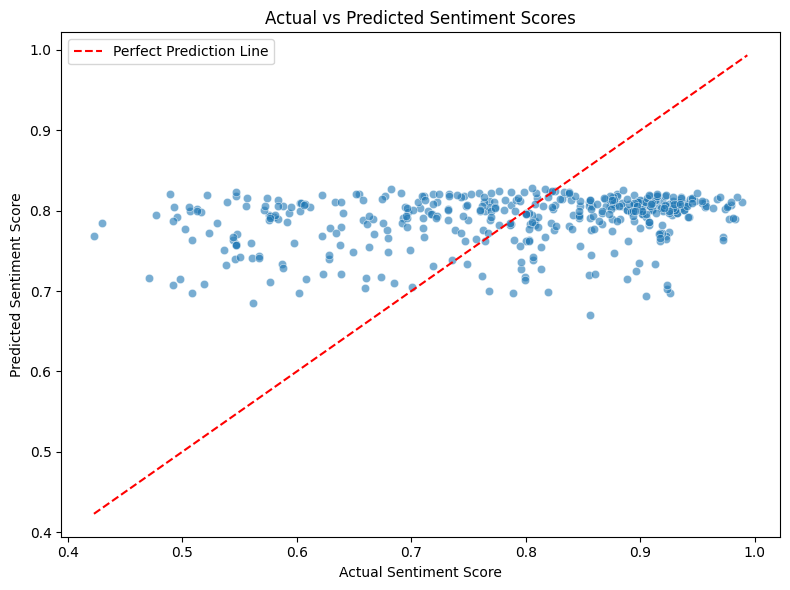

In [191]:
# Predict on test set
y_pred = model.predict(X_test)

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', label='Perfect Prediction Line')
plt.xlabel("Actual Sentiment Score")
plt.ylabel("Predicted Sentiment Score")
plt.title("Actual vs Predicted Sentiment Scores")
plt.legend()
plt.tight_layout()
plt.savefig("visualizations/actual_and_predicted_sentiment_scores.png")
plt.show()


**🔍 Interpretation:**
- The red dashed line indicates a perfect prediction.
- The predicted values are clustered tightly between 0.75 and 0.82.
- The model fails to capture variability in actual sentiment scores, consistently overpredicting lower scores and underpredicting higher ones.
- This result aligns with a low R² value, indicating poor model fit.

**🔹 Plot 2: Residual Plot (Prediction Errors)**

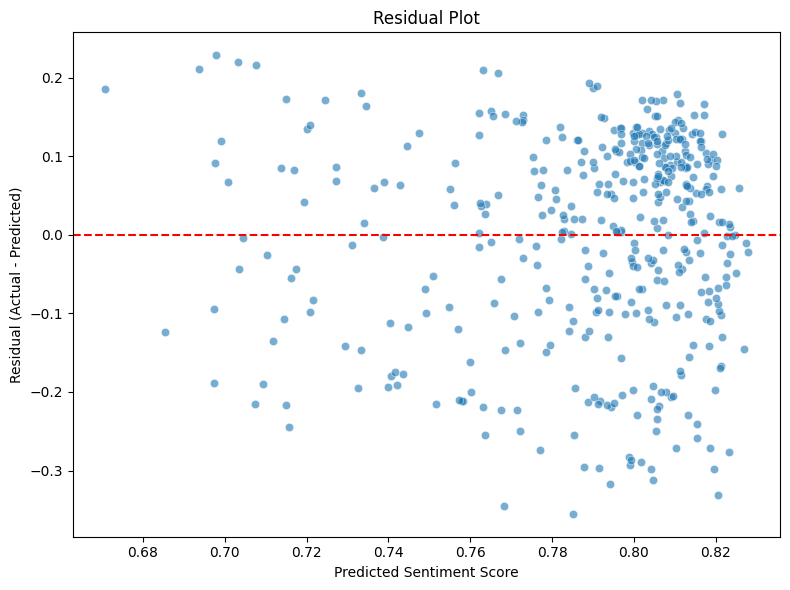

In [193]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Predicted Sentiment Score")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.tight_layout()
plt.savefig("visualizations/residual_plot.png")
plt.show()


**🔍 Interpretation:**
- Residuals appear randomly scattered around 0, suggesting no clear non-linearity, but with significant variance.
- Many predictions are off by ±0.1 or more, and some even reach ±0.3.
- This reinforces the lack of explanatory power of the linear regression model.

**📌 Conclusion:**
Although the linear model is simple to interpret, it does not generalize well in this context. This is likely due to:
- Limited feature complexity
- Lack of interaction or time-based patterns
- High noise in email sentiment patterns


**🔹 Suggestions:**
- Use NLP techniques such as TF-IDF or embeddings for richer representations.
- Try tree-based models like Gradient Boosted Trees.
- Include more metadata (e.g., subject line features, time of day, response delays).


### 📊 Step 9: Model Comparison:

To further explore whether nonlinear relationships exist between the features and sentiment scores, we trained a Random Forest Regressor as a comparison to our baseline linear regression model.

In [225]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest Regressor with a fixed random state for reproducibility
rf_model = RandomForestRegressor(random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Predict on the training set
y_train_pred_rf = rf_model.predict(X_train)

# Predict on the test set
y_test_pred_rf = rf_model.predict(X_test)

# Evaluate Training Performance 
rf_train_r2 = r2_score(y_train, y_train_pred_rf)
rf_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
rf_train_mae = mean_absolute_error(y_train, y_train_pred_rf)

# Evaluate Test Performance 
rf_test_r2 = r2_score(y_test, y_test_pred_rf)
rf_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
rf_test_mae = mean_absolute_error(y_test, y_test_pred_rf)

# Display the results
print("Random Forest Regressor Performance:")
print("Training Performance:")
print(f"R^2 Score: {rf_train_r2:.3f}")
print(f"RMSE: {rf_train_rmse:.3f}")
print(f"MAE: {rf_train_mae:.3f}\n")

print("Test Performance:")
print(f"R^2 Score: {rf_test_r2:.3f}")
print(f"RMSE: {rf_test_rmse:.3f}")
print(f"MAE: {rf_test_mae:.3f}")

Random Forest Regressor Performance:
Training Performance:
R^2 Score: 0.878
RMSE: 0.050
MAE: 0.039

Test Performance:
R^2 Score: 0.087
RMSE: 0.130
MAE: 0.103


#### 💬 Interpretation:
**Strong training performance:** The model fits the training data very well (R² = 0.878), suggesting that Random Forest can capture complex, nonlinear patterns.

**Poor test performance:** However, the model generalizes poorly to unseen data (R² = 0.087), which likely indicates overfitting — the model learned the noise in the training set rather than general patterns.

**RMSE and MAE Gap:** The increase in RMSE and MAE from training to test also supports the overfitting observation.

#### ✅ Takeaway:  

While Linear Regression served as a baseline, Random Forest showed significantly better performance on the training set, suggesting the presence of nonlinear relationships in the features. However, its poor generalization highlights the need for regularization or more robust feature engineering to reduce overfitting.